In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import os
print("Drive Mounted! Path: /content/drive/MyDrive")
print("Python Version:", sys.version)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive Mounted! Path: /content/drive/MyDrive
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
# Installs (Run once – 5-10 min)
!pip install transformers datasets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install sumy gensim sentence-transformers scikit-learn rouge-score bert-score
!pip install pandas numpy matplotlib seaborn nltk wordcloud

# NLTK Downloads
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

print("Installs Complete!")

Looking in indexes: https://download.pytorch.org/whl/cu118
Installs Complete!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Project Base Path in Drive
base_path = '/content/drive/MyDrive/legal_summarization'
os.makedirs(base_path, exist_ok=True)
os.makedirs(f'{base_path}/data', exist_ok=True)
os.makedirs(f'{base_path}/src', exist_ok=True)
os.makedirs(f'{base_path}/models', exist_ok=True)
os.makedirs(f'{base_path}/results', exist_ok=True)
os.makedirs(f'{base_path}/logs', exist_ok=True)

# requirements.txt Save
!pip freeze > {base_path}/requirements.txt

print(f"Folders Created in: {base_path}")
print("requirements.txt Saved!")

Folders Created in: /content/drive/MyDrive/legal_summarization
requirements.txt Saved!


In [ ]:
import torch
from transformers import AutoTokenizer, pipeline
from datasets import load_dataset
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

# Tests
print("1. GPU:", "Available" if torch.cuda.is_available() else "Not Available (CPU OK for Steps 1-3)")
print("2. HF Dataset Test:", load_dataset("rishiai/indian-court-judgements-and-its-summaries", split='train[:1]'))
print("3. Tokenizer:", AutoTokenizer.from_pretrained("facebook/bart-base"))
print("4. Extractive Test:", TextRankSummarizer())
print("5. NLTK:", sent_tokenize("Test sentence. Another one."))
print("6. Pandas:", pd.DataFrame({'test': [1,2]}))

# Quick BART Pipeline Test
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
test_text = "This is a short test for legal summary."
summary = summarizer(test_text, max_length=20, min_length=5)
print("7. BART Pipeline:", summary[0]['summary_text'])

print("\n🎉 Step 1 Complete! Setup Ready.")

1. GPU: Not Available (CPU OK for Steps 1-3)
2. HF Dataset Test: Dataset({
    features: ['ID', 'Judgment', 'Summary'],
    num_rows: 1
})
3. Tokenizer: BartTokenizerFast(name_or_path='facebook/bart-base', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", r

Device set to use cpu
Your max_length is set to 20, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


7. BART Pipeline: This is a short test for legal summary. This is not a legal summary of the

🎉 Step 1 Complete! Setup Ready.


In [ ]:
from datasets import load_dataset
import pandas as pd

# Load Full Dataset
dataset = load_dataset("rishiai/indian-court-judgements-and-its-summaries")
print("Dataset Info:")
print(dataset)  # Full size, splits

# Load 'train' split (assume all data there)
df = pd.DataFrame(dataset['train'])
print(f"\nShape: {df.shape}")  # Expect ~6944 rows
print("Columns:", df.columns.tolist())  # ['ID', 'Judgment', 'Summary']

# Rename Columns for Simplicity (lowercase)
df = df.rename(columns={'Judgment': 'judgment', 'Summary': 'summary'})
df = df.drop(columns=['ID'], errors='ignore')  # Drop ID if not needed
print(df.head(2))  # First 2 samples

# Nulls & Duplicates
print(f"\nNulls - Judgment: {df['judgment'].isnull().sum()}, Summary: {df['summary'].isnull().sum()}")
df = df.dropna(subset=['judgment', 'summary'])  # Drop nulls
df = df.drop_duplicates(subset=['judgment'])  # Drop dups
print(f"Clean Shape: {df.shape}")

# Save Raw
df.to_csv(f'{base_path}/data/raw_df.csv', index=False)
print("Raw DF Saved!")

Dataset Info:
DatasetDict({
    train: Dataset({
        features: ['ID', 'Judgment', 'Summary'],
        num_rows: 6944
    })
})

Shape: (6944, 3)
Columns: ['ID', 'Judgment', 'Summary']
                                            judgment  \
0  Appeal No. LXVI of 1949. Appeal from the High ...   
1  XXIX of 1950. Application under article 32 of ...   

                                             summary  
0  The charge created in respect of municipal pro...  
1  Section 7 (1) (c) of the East Punjab Public Sa...  

Nulls - Judgment: 0, Summary: 2
Clean Shape: (6917, 2)
Raw DF Saved!


In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize

# Word & Sentence Counts
df['judgment_words'] = df['judgment'].apply(lambda x: len(word_tokenize(str(x))))
df['judgment_sents'] = df['judgment'].apply(lambda x: len(sent_tokenize(str(x))))
df['summary_words'] = df['summary'].apply(lambda x: len(word_tokenize(str(x))))
df['summary_sents'] = df['summary'].apply(lambda x: len(sent_tokenize(str(x))))

# Stats
print("Length Stats:")
print(df[['judgment_words', 'judgment_sents', 'summary_words', 'summary_sents']].describe())
print(f"\nAvg Judgment Words: {df['judgment_words'].mean():.2f}")
print(f"Avg Judgment Sentences: {df['judgment_sents'].mean():.2f}")
print(f"\nAvg Summary Words: {df['summary_words'].mean():.2f}")
print(f"Avg Summary Sentences: {df['summary_sents'].mean():.2f}")

# Compression Ratio
df['compression_ratio'] = df['summary_words'] / df['judgment_words']
print(f"Avg Compression: {df['compression_ratio'].mean():.3f}")

Length Stats:
       judgment_words  judgment_sents  summary_words  summary_sents
count     6917.000000     6917.000000    6917.000000    6917.000000
mean      4703.958508      166.587538     916.934509      32.954026
std       5509.508374      178.907333     987.162040      34.764259
min        114.000000       13.000000      40.000000       1.000000
25%       2159.000000       82.000000     455.000000      16.000000
50%       3372.000000      122.000000     692.000000      25.000000
75%       5347.000000      190.000000    1051.000000      38.000000
max     150538.000000     4438.000000   30218.000000    1066.000000

Avg Judgment Words: 4703.96
Avg Judgment Sentences: 166.59

Avg Summary Words: 916.93
Avg Summary Sentences: 32.95
Avg Compression: 0.238


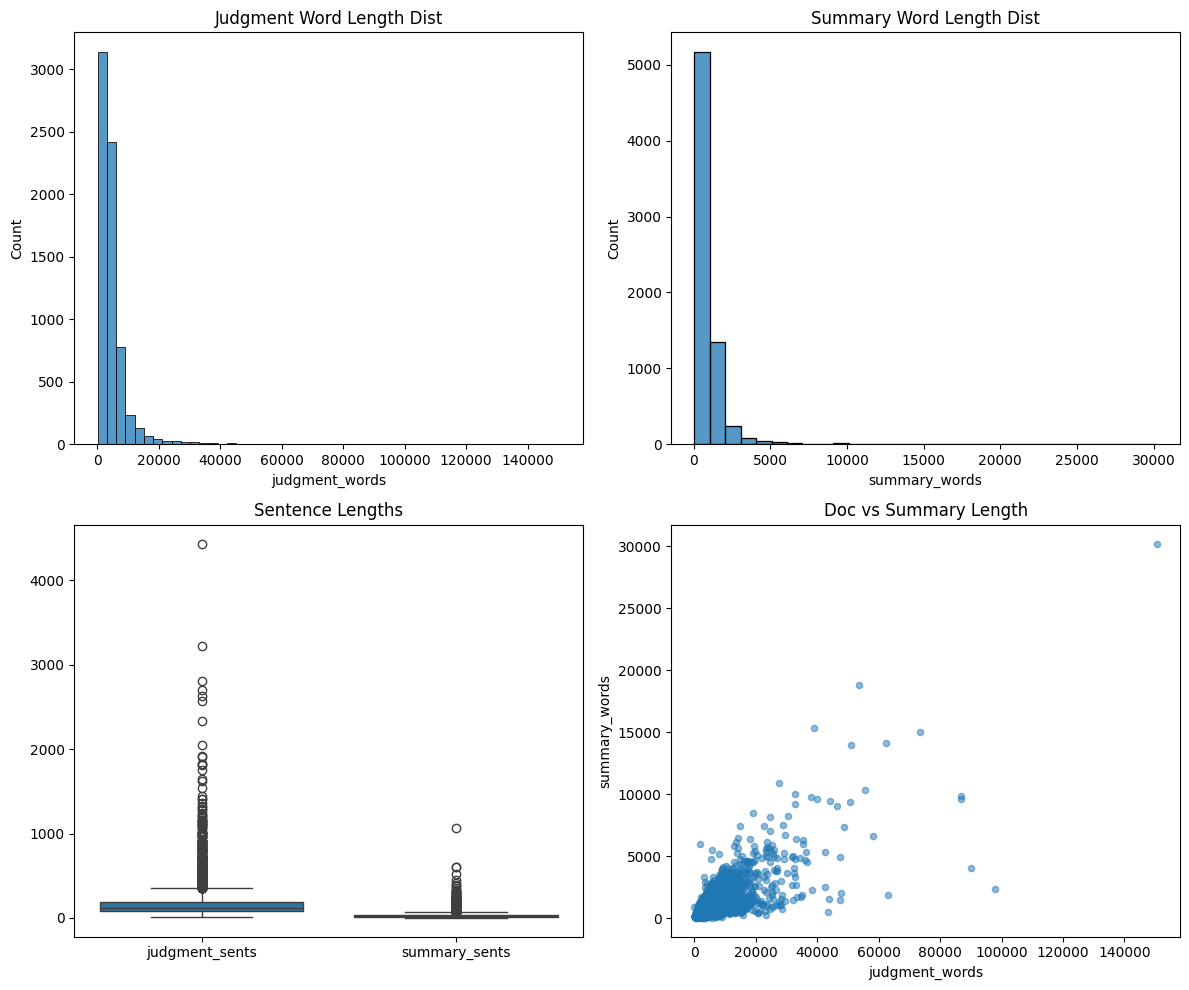

Top 20 Judgment Words: [('the', 3079867), ('and', 682952), ('that', 511675), ('was', 325173), ('for', 286475), ('not', 237670), ('court', 189427), ('section', 176738), ('which', 173095), ('this', 170964), ('under', 150519), ('act', 141375), ('with', 140151), ('any', 121209), ('from', 115097), ('has', 103877), ('been', 99810), ('are', 99322), ('case', 97087), ('have', 96695)]


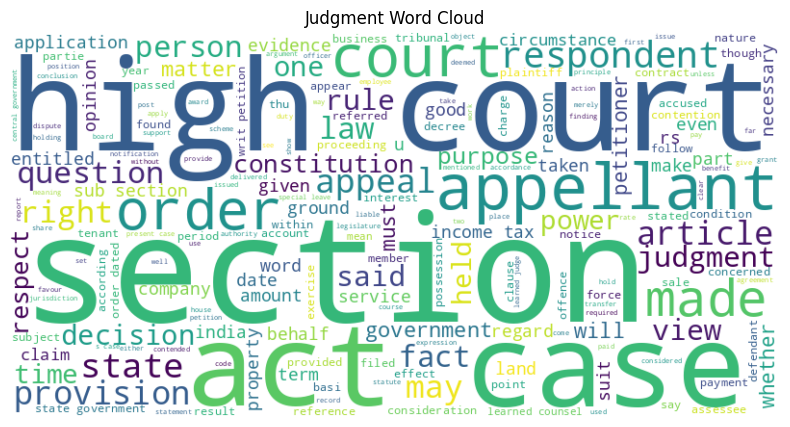

Top 20 Summary Words: [('the', 621792), ('and', 137189), ('that', 79749), ('was', 69766), ('not', 52203), ('for', 50969), ('court', 41158), ('section', 39644), ('under', 35728), ('act', 32661), ('which', 28099), ('with', 23782), ('state', 20760), ('were', 20261), ('from', 20059), ('had', 19171), ('any', 18705), ('appellant', 18398), ('this', 17800), ('high', 17254)]


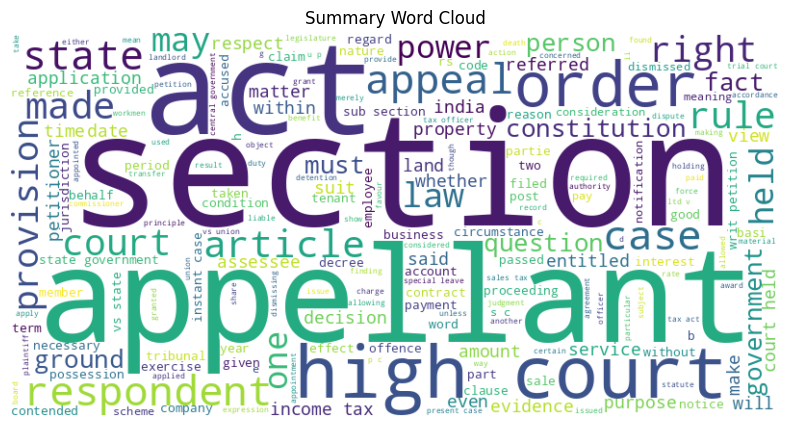

EDA Plots & Stats Saved!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter

# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['judgment_words'], bins=50, ax=axes[0,0]).set_title('Judgment Word Length Dist')
sns.histplot(df['summary_words'], bins=30, ax=axes[0,1]).set_title('Summary Word Length Dist')
sns.boxplot(data=df[['judgment_sents', 'summary_sents']], ax=axes[1,0]).set_title('Sentence Lengths')
df.plot.scatter(x='judgment_words', y='summary_words', ax=axes[1,1], alpha=0.5).set_title('Doc vs Summary Length')
plt.tight_layout()
plt.savefig(f'{base_path}/results/eda_plots.png', dpi=300)
plt.show()

# Word Clouds & Top Words
all_judg_text = ' '.join(df['judgment'].astype(str)).lower()
judg_words = re.findall(r'\b[a-zA-Z]{3,}\b', all_judg_text)
judg_counter = Counter(judg_words)
print("Top 20 Judgment Words:", judg_counter.most_common(20))

wc_judg = WordCloud(width=800, height=400, background_color='white').generate(all_judg_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_judg, interpolation='bilinear')
plt.axis('off')
plt.title('Judgment Word Cloud')
plt.savefig(f'{base_path}/results/judgment_wc.png', dpi=300)
plt.show()

all_summ_text = ' '.join(df['summary'].astype(str)).lower()
summ_words = re.findall(r'\b[a-zA-Z]{3,}\b', all_summ_text)
summ_counter = Counter(summ_words)
print("Top 20 Summary Words:", summ_counter.most_common(20))

wc_summ = WordCloud(width=800, height=400, background_color='white').generate(all_summ_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_summ, interpolation='bilinear')
plt.axis('off')
plt.title('Summary Word Cloud')
plt.savefig(f'{base_path}/results/summary_wc.png', dpi=300)
plt.show()

# Save Updated DF
df.to_csv(f'{base_path}/data/raw_df_with_stats.csv', index=False)
print("EDA Plots & Stats Saved!")

In [ ]:
pd.read_csv(f'{base_path}/data/raw_df_with_stats.csv').head(2)

In [ ]:
sample_judgment = """ costs in the appeal. Appeal allowed. """
sample_summary = """ o. ' secure the discharge of a liability of a capi tal nature; and an "annual charge" means a charge to secure an annual liabili ty. 554 """
# Analysis
sample_j_words = len(word_tokenize(sample_judgment))
sample_j_sents = len(sent_tokenize(sample_judgment))
sample_s_words = len(word_tokenize(sample_summary))
sample_s_sents = len(sent_tokenize(sample_summary))
ratio = sample_s_words / sample_j_words

print(f"Sample Judgment: {sample_j_words} words, {sample_j_sents} sentences")
print(f"Sample Summary: {sample_s_words} words, {sample_s_sents} sentences")
print(f"Compression Ratio: {ratio:.3f}")

In [ ]:
!pip install pyspellchecker

In [ ]:
import re
from collections import Counter
import nltk
nltk.download('words')  # English dict (~230k words)
from nltk.corpus import words

english_words = set(words.words())  # Known English words

# Your Legal Glossary (For Validation)
legal_terms = ['court', 'section', 'act', 'case', 'property', 'tax', 'charge', 'income', 'indian', 'high', 'state', 'appellant', 'respondent', 'judgment', 'liability', 'deduction', 'annual', 'capital', 'tribunal', 'commissioner', 'urban', 'municipal', 'immovable', 'bona fide', 'privy council']

all_known_words = english_words.union(legal_terms)  # Combined dict

def detect_true_broken(text):
    # Find splits
    splits = re.findall(r'\b(\w{2,6})\s+(\w{2,6})\b', text.lower())
    real_broken = []
    for part1, part2 in splits:
        combined = part1 + part2
        # True broken: Combined is known word, but parts are not (OCR split)
        if combined in all_known_words and part1 not in all_known_words and part2 not in all_known_words:
            real_broken.append((part1, part2, combined))
    return real_broken

# From All Summaries (Short, Fast)
print("True Broken from Summaries")
summ_text = ' '.join(df['summary'].str.lower())
true_broken_summ = detect_true_broken(summ_text)
summ_counter = Counter(true_broken_summ)

print("True Broken from Summaries:")
for pair, combined in summ_counter.most_common(len(summ_counter)):
    print(f"r'{pair[0]} {pair[1]}': '{pair[0] + pair[1]}',  # Combined: {combined}")

# From All Judgments (Longer, 1 min)
print("\nTrue Broken from Judgments")
judg_text = ' '.join(df['judgment'].str.lower())
true_broken_judg = detect_true_broken(judg_text)
judg_counter = Counter(true_broken_judg)

print("True Broken from Judgments:")
for pair, combined in judg_counter.most_common(len(summ_counter)):
    print(f"r'{pair[0]} {pair[1]}': '{pair[0] + pair[1]}',  # Combined: {combined}")

# Save
summ_broken_df = pd.DataFrame(summ_counter.most_common(len(summ_counter)), columns=['broken_pair', 'count'])
judg_broken_df = pd.DataFrame(judg_counter.most_common(len(summ_counter)), columns=['broken_pair', 'count'])
summ_broken_df.to_csv(f'{base_path}/results/true_broken_summ.csv', index=False)
judg_broken_df.to_csv(f'{base_path}/results/true_broken_judg.csv', index=False)
print("\nTrue Broken CSVs Saved!")

In [ ]:
summ_broken_df

In [ ]:
judg_broken_df

In [ ]:
import pandas as pd
import re
import ast
from tqdm import tqdm
import time

# === Step 1: Load the main dataset ===
df = pd.read_csv(f'{base_path}/data/raw_df_with_stats.csv')
print(f"Loaded dataset: {len(df)} rows")

# === Step 2: Load broken-word lists ===
summ_broken = pd.read_csv(f'{base_path}/results/true_broken_summ.csv')
judg_broken = pd.read_csv(f'{base_path}/results/true_broken_judg.csv')

# === Step 3: Parse broken pairs correctly ===
def parse_broken_pair(pair_str):
    """
    Parse string representation of tuple: "('commis', 'sioner', 'commissioner')"
    Returns: pattern (e.g., 'commis sioner'), correction (e.g., 'commissioner')
    """
    try:
        # Use ast.literal_eval to safely parse the tuple string
        parts = ast.literal_eval(str(pair_str))
        if isinstance(parts, tuple) and len(parts) == 3:
            part1, part2, combined = parts
            pattern = f"{part1} {part2}"
            return pattern, combined
    except:
        pass
    return None, None

# === Step 4: Build correction dictionary ===
corrections = {}

for df_src in [summ_broken, judg_broken]:
    for _, row in df_src.iterrows():
        pattern, combined = parse_broken_pair(row['broken_pair'])
        if pattern and combined:
            corrections[pattern] = combined

print(f"✅ Loaded {len(corrections)} unique correction rules")
print(f"Sample corrections: {list(corrections.items())[:5]}")

# === Step 5: Clean tabs and extra whitespace ===
def clean_whitespace(text):
    """Remove tabs, extra spaces, and normalize whitespace"""
    if pd.isna(text) or text == '':
        return text

    text = str(text)
    # Replace tabs with single space
    text = text.replace('\t', ' ')
    # Replace multiple spaces with single space
    text = re.sub(r' +', ' ', text)
    # Remove leading/trailing whitespace
    text = text.strip()

    return text

# === Step 6: Define correction function with case-insensitive replacement ===
def fix_broken_words(text):
    """
    Replace broken word patterns with their corrected versions.
    Handles case-insensitive matching while preserving original case when possible.
    """
    if pd.isna(text) or text == '':
        return text

    text = str(text)

    # First clean tabs and extra whitespace
    text = clean_whitespace(text)

    # Sort patterns by length (longest first) to handle overlapping patterns
    sorted_corrections = sorted(corrections.items(), key=lambda x: len(x[0]), reverse=True)

    for broken, correct in sorted_corrections:
        # Create case-insensitive pattern with word boundaries
        pattern = r'\b' + re.escape(broken) + r'\b'


        # Find all matches with their positions
        matches = list(re.finditer(pattern, text, flags=re.IGNORECASE))

        # Replace from end to start to preserve positions
        for match in reversed(matches):
            original = match.group()

            # Preserve original case pattern
            if original.isupper():
                replacement = correct.upper()
            elif original[0].isupper():
                replacement = correct.capitalize()
            else:
                replacement = correct.lower()

            text = text[:match.start()] + replacement + text[match.end():]

    return text

# === Step 7: Test on a sample first ===
print("\n=== Testing on sample text ===")
sample_text = "The commis sioner has\tissued a peti tion\tto the tribu nal regarding the ques tion."
print(f"Before: {repr(sample_text)}")
print(f"After:  {repr(fix_broken_words(sample_text))}")

# === Step 8: Estimate processing time ===
print("\n=== Estimating processing time ===")
# Test on 10 rows to estimate
test_sample = df['judgment'].head(10)
start_time = time.time()
for text in test_sample:
    fix_broken_words(text)
test_time = time.time() - start_time
avg_time_per_row = test_time / 10

total_rows = len(df)
estimated_time = (avg_time_per_row * total_rows * 2) / 60  # *2 for both columns
print(f"Estimated time: {estimated_time:.1f} minutes for {total_rows} rows ({len(corrections)} corrections)")

# === Step 9: Apply to entire dataset with progress bar ===
print("\n=== Applying corrections to entire dataset ===")

# Initialize tqdm for pandas
tqdm.pandas()

print("Processing judgments...")
df['judgment_cleaned'] = df['judgment'].progress_apply(fix_broken_words)

print("\nProcessing summaries...")
df['summary_cleaned'] = df['summary'].progress_apply(fix_broken_words)

# === Step 10: Count changes ===
judgment_changes = (df['judgment'] != df['judgment_cleaned']).sum()
summary_changes = (df['summary'] != df['summary_cleaned']).sum()

# Count tab removals
judgment_tabs = df['judgment'].astype(str).str.contains('\t').sum()
summary_tabs = df['summary'].astype(str).str.contains('\t').sum()

print(f"\n✅ Corrections applied:")
print(f"   - Judgments with tabs removed: {judgment_tabs}")
print(f"   - Summaries with tabs removed: {summary_tabs}")
print(f"   - Judgments modified: {judgment_changes}/{len(df)}")
print(f"   - Summaries modified: {summary_changes}/{len(df)}")

# === Step 11: Show examples of changes ===
print("\n=== Sample of corrections ===")
changed_indices = df[df['judgment'] != df['judgment_cleaned']].head(3).index

for idx in changed_indices:
    print(f"\nRow {idx} - Judgment snippet:")
    orig = df.loc[idx, 'judgment'][:300]
    cleaned = df.loc[idx, 'judgment_cleaned'][:300]
    print(f"Original: {repr(orig)}...")
    print(f"Cleaned:  {repr(cleaned)}...")
    print("-" * 80)

# === Step 12: Verify tab removal ===
tabs_remaining_j = df['judgment_cleaned'].astype(str).str.contains('\t').sum()
tabs_remaining_s = df['summary_cleaned'].astype(str).str.contains('\t').sum()
print(f"\n✅ Tab character verification:")
print(f"   - Tabs remaining in judgments: {tabs_remaining_j}")
print(f"   - Tabs remaining in summaries: {tabs_remaining_s}")

# === Step 13: Quality check - show some broken words that were fixed ===
print("\n=== Quality Check: Verifying fixes ===")
test_patterns = ['commis sioner', 'peti tion', 'tribu nal', 'ques tion']
for pattern in test_patterns:
    orig_count = df['judgment'].astype(str).str.contains(pattern, case=False, regex=False).sum()
    new_count = df['judgment_cleaned'].astype(str).str.contains(pattern, case=False, regex=False).sum()
    if orig_count > 0:
        print(f"'{pattern}': {orig_count} occurrences → {new_count} remaining")

# === Step 14: Save cleaned version ===
df['judgment'] = df['judgment_cleaned']
df['summary'] = df['summary_cleaned']
df = df.drop(['judgment_cleaned', 'summary_cleaned'], axis=1)

output_path = f'{base_path}/data/raw_df_with_stats_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned dataset saved as: {output_path}")

# Optional: Save correction log
correction_log = pd.DataFrame(list(corrections.items()), columns=['broken_pattern', 'correction'])
correction_log = correction_log.sort_values('broken_pattern')
log_path = f'{base_path}/results/correction_log.csv'
correction_log.to_csv(log_path, index=False)
print(f"✅ Correction log saved as: {log_path}")

print("\n" + "="*80)
print("CLEANING COMPLETE!")
print("="*80)

In [ ]:
byedf = pd.read_csv('/content/drive/MyDrive/legal_summarization/data/raw_df_with_stats.csv')
byedf["judgment"][0]

'Appeal No. LXVI of 1949. Appeal from the High Court of judicature\t Bombay\t in a reference under section 66 of the Indian Income tax Act\t 1022. K.M. Munshi (N. P. Nathvani\t with him)\t for the appel lant. \' M.C. Setalvad\t Attorney General for India (H. J. Umrigar\t with him)\t for the respondent. 1950. May 26. The judgment of the Court was delivered by MEHR CHAND MAHAJAN J. This is an appeal against a judgment of the High Court of Judicature at Bombay in an income tax matter and it raises the question whether munici pal property tax and urban immoveable property tax payable under the relevant Bombay Acts are allowable deductions under section 9 (1) (iv) of the Indian Income tax Act. The assessee company is an investment company deriving its income from properties in the city of Bombay. For the assessment year 1940 41 the net income of the assessee under the head "property" was computed by the Income tax Officer in the sum of Rs. 6\t21\t764 after deducting from gross rents certain

In [ ]:
hidf = pd.read_csv('/content/drive/MyDrive/legal_summarization/data/raw_df_with_stats_cleaned.csv')
hidf["judgment"][0]

'Appeal No. LXVI of 1949. Appeal from the High Court of judicature Bombay in a reference under section 66 of the Indian Income tax Act 1022. K.M. Munshi (N. P. Nathvani with him) for the appel lant. M.C. Setalvad Attorney General for India (H. J. Umrigar with him) for the respondent. 1950. May 26. The judgment of the Court was delivered by MEHR CHAND MAHAJAN J. This is an appeal against a judgment of the High Court of Judicature at Bombay in an income tax matter and it raises the question whether munici pal property tax and urban immoveable property tax payable under the relevant Bombay Acts are allowable deductions under section 9 (1) (iv) of the Indian Income tax Act. The assessee company is an investment company deriving its income from properties in the city of Bombay. For the assessment year 1940 41 the net income of the assessee under the head "property" was computed by the Income tax Officer in the sum of Rs. 6 21 764 after deducting from gross rents certain payments. The compan

In [ ]:
df["judgment"][0]

In [ ]:
import re
from collections import Counter
import nltk
nltk.download('words')  # English dict (~230k words)
from nltk.corpus import words

english_words = set(words.words())  # Known English words

# Your Legal Glossary (For Validation)
legal_terms = ['court', 'section', 'act', 'case', 'property', 'tax', 'charge', 'income', 'indian', 'high', 'state', 'appellant', 'respondent', 'judgment', 'liability', 'deduction', 'annual', 'capital', 'tribunal', 'commissioner', 'urban', 'municipal', 'immovable', 'bona fide', 'privy council']

all_known_words = english_words.union(legal_terms)  # Combined dict

def detect_true_broken(text):
    # Find splits
    splits = re.findall(r'\b(\w{2,32})\s+(\w{2,32})\b', text.lower())
    real_broken = []
    for part1, part2 in splits:
        combined = part1 + part2
        # True broken: Combined is known word, but parts are not (OCR split)
        if combined in all_known_words and part1 not in all_known_words and part2 not in all_known_words:
            real_broken.append((part1, part2, combined))
    return real_broken

# From All Summaries (Short, Fast)
print("True Broken from Summaries")
summ_text = ' '.join(df['summary'].str.lower())
true_broken_summ = detect_true_broken(summ_text)
summ_counter = Counter(true_broken_summ)

print("True Broken from Summaries:")
for pair, combined in summ_counter.most_common(len(summ_counter)):
    print(f"r'{pair[0]} {pair[1]}': '{pair[0] + pair[1]}',  # Combined: {combined}")

# From All Judgments (Longer, 1 min)
print("\nTrue Broken from Judgments")
judg_text = ' '.join(df['judgment'].str.lower())
true_broken_judg = detect_true_broken(judg_text)
judg_counter = Counter(true_broken_judg)

print("True Broken from Judgments:")
for pair, combined in judg_counter.most_common(len(summ_counter)):
    print(f"r'{pair[0]} {pair[1]}': '{pair[0] + pair[1]}',  # Combined: {combined}")

# # Save
summ_broken_df = pd.DataFrame(summ_counter.most_common(len(summ_counter)), columns=['broken_pair', 'count'])
judg_broken_df = pd.DataFrame(judg_counter.most_common(len(summ_counter)), columns=['broken_pair', 'count'])
summ_broken_df.to_csv(f'{base_path}/results/true_broken_summ.csv', mode='a', header=False, index=False)
judg_broken_df.to_csv(f'{base_path}/results/true_broken_judg.csv', mode='a', header=False, index=False)
print("\nTrue Broken CSVs Saved!")

In [ ]:
def find_legal_term_splits(text, legal_terms_list):
    """Find splits where the combined form is a known legal term"""
    splits = re.findall(r'\b(\w{2,32})\s+(\w{2,32})\b', text.lower())
    legal_splits = []

    for part1, part2 in splits:
        combined = part1 + part2
        if combined in legal_terms_list:
            legal_splits.append((part1, part2, combined))

    return Counter(legal_splits)

# Find all splits of your known legal terms
legal_splits_summ = find_legal_term_splits(summ_text, legal_terms)
legal_splits_judg = find_legal_term_splits(judg_text, legal_terms)

print("Legal Term Splits from Summaries:")
for (p1, p2, combined), count in legal_splits_summ.most_common():
    print(f"r'{p1} {p2}': '{combined}',  # Combined: {count}")

print("\nLegal Term Splits from Judgments:")
for (p1, p2, combined), count in legal_splits_judg.most_common():
    print(f"r'{p1} {p2}': '{combined}',  # Combined: {count}")

# Expand your legal terms list first
expanded_legal_terms = legal_terms + [
    'appellant', 'respondent', 'petitioner', 'complainant', 'defendant',
    'plaintiff', 'prosecution', 'accused', 'witness', 'evidence',
    'testimony', 'affidavit', 'summons', 'warrant', 'bail', 'appeal',
    'jurisdiction', 'constitutional', 'legislature', 'parliament',
    'amendment', 'regulation', 'ordinance', 'statute', 'precedent',
    'judgment', 'decree', 'order', 'injunction', 'mandamus',
    'certiorari', 'habeas', 'corpus', 'quash', 'revision'
    # Add more legal terms as needed
]

def find_all_legal_overrides(text, legal_dict):
    """Find all potential legal overrides systematically"""
    splits = re.findall(r'\b(\w{2,32})\s+(\w{2,32})\b', text.lower())
    overrides = []

    for part1, part2 in splits:
        combined = part1 + part2
        # If combined is a legal term, it's a candidate for override
        if combined in legal_dict:
            overrides.append((part1, part2, combined))

    return Counter(overrides)

# Find comprehensive overrides
all_overrides_summ = find_all_legal_overrides(summ_text, expanded_legal_terms)
all_overrides_judg = find_all_legal_overrides(judg_text, expanded_legal_terms)

print("All Legal Overrides from Summaries:")
for (p1, p2, combined), count in all_overrides_summ.most_common(100):
    print(f"r'{p1} {p2}': '{combined}',  # Count: {count}")

print("\nAll Legal Overrides from Judgments:")
for (p1, p2, combined), count in all_overrides_judg.most_common(100):
    print(f"r'{p1} {p2}': '{combined}',  # Count: {count}")

def smart_override_detection(text, min_frequency=2):
    """Find overrides based on frequency and legal relevance"""
    splits = re.findall(r'\b(\w{2,32})\s+(\w{2,32})\b', text.lower())
    override_candidates = []

    for part1, part2 in splits:
        combined = part1 + part2

        # Candidate if: combined is valid AND appears frequently
        # OR combined is longer/more meaningful than parts
        if (combined in all_known_words and
            (len(combined) > max(len(part1), len(part2)) + 2 or
             combined in expanded_legal_terms)):
            override_candidates.append((part1, part2, combined))

    counter = Counter(override_candidates)
    # Return only frequent ones
    return [(pair, count) for pair, count in counter.most_common() if count >= min_frequency]

# Get smart overrides
smart_overrides_summ = smart_override_detection(summ_text)
smart_overrides_judg = smart_override_detection(judg_text)

print("Smart Overrides from Summaries:")
for (p1, p2, combined), count in smart_overrides_summ:
    print(f"r'{p1} {p2}': '{combined}',  # Frequency: {count}")

print("\nSmart Overrides from Judgments:")
for (p1, p2, combined), count in smart_overrides_judg:
    print(f"r'{p1} {p2}': '{combined}',  # Frequency: {count}")


def create_final_override_dict():
    """Combine all methods to create comprehensive override dictionary"""

    # Get overrides from all methods
    legal_splits = find_legal_term_splits(judg_text + ' ' + summ_text, expanded_legal_terms)
    potential = find_potential_overrides(judg_text + ' ' + summ_text, top_n=300)
    smart = dict(smart_override_detection(judg_text + ' ' + summ_text, min_frequency=2))

    # Combine and deduplicate
    final_overrides = {}

    # Add legal term splits (highest priority)
    for (p1, p2, combined), count in legal_splits.most_common():
        final_overrides[f"{p1} {p2}"] = combined

    # Add high-frequency potential overrides
    for (p1, p2, combined), count in potential:
        if count >= 3:  # Only include frequent ones
            final_overrides[f"{p1} {p2}"] = combined

    # Add smart overrides
    for (p1, p2, combined), count in smart.items():
        final_overrides[f"{p1} {p2}"] = combined

    return final_overrides

# Generate the final override dictionary
final_overrides = create_final_override_dict()

print("FINAL LEGAL OVERRIDE DICTIONARY:")
print("LEGAL_OVERRIDES = {")
for broken, fixed in sorted(final_overrides.items()):
    print(f"    r'{broken}': '{fixed}',")
print("}")

print(f"\nTotal overrides found: {len(final_overrides)}")

In [ ]:
summ_broken_df

In [ ]:
dhedf = pd.read_csv(f'{base_path}/results/true_broken_summ.csv')
dhedf.shape

#Run this first

In [ ]:
import pandas as pd
import re
import ast
from tqdm import tqdm
import time


base_path = '/content/drive/MyDrive/legal_summarization'
# === Step 1: Load the main dataset ===
df = pd.read_csv(f'{base_path}/data/raw_df_with_stats_cleaned.csv')
print(f"Loaded dataset: {len(df)} rows")

# === Step 2: Load broken-word lists ===
summ_broken = pd.read_csv(f'{base_path}/results/true_broken_summ.csv')
judg_broken = pd.read_csv(f'{base_path}/results/true_broken_judg.csv')

# === Step 3: Parse broken pairs correctly ===
def parse_broken_pair(pair_str):
    """
    Parse string representation of tuple: "('commis', 'sioner', 'commissioner')"
    Returns: pattern (e.g., 'commis sioner'), correction (e.g., 'commissioner')
    """
    try:
        # Use ast.literal_eval to safely parse the tuple string
        parts = ast.literal_eval(str(pair_str))
        if isinstance(parts, tuple) and len(parts) == 3:
            part1, part2, combined = parts
            pattern = f"{part1} {part2}"
            return pattern, combined
    except:
        pass
    return None, None

# === Step 4: Build correction dictionary ===
corrections = {}

for df_src in [summ_broken, judg_broken]:
    for _, row in df_src.iterrows():
        pattern, combined = parse_broken_pair(row['broken_pair'])
        if pattern and combined:
            corrections[pattern] = combined

print(f"✅ Loaded {len(corrections)} unique correction rules")
print(f"Sample corrections: {list(corrections.items())[:5]}")

# === Step 5: Clean tabs and extra whitespace ===
def clean_whitespace(text):
    """Remove tabs, extra spaces, and normalize whitespace"""
    if pd.isna(text) or text == '':
        return text

    text = str(text)
    # Replace tabs with single space
    text = text.replace('\t', ' ')
    text = text.replace('\'',' ')
    # Replace multiple spaces with single space
    text = re.sub(r' +', ' ', text)
    # Remove leading/trailing whitespace
    text = text.strip()

    return text

# === Step 6: Define correction function with case-insensitive replacement ===
def fix_broken_words(text):
    """
    Replace broken word patterns with their corrected versions.
    Handles case-insensitive matching while preserving original case when possible.
    """
    if pd.isna(text) or text == '':
        return text

    text = str(text)

    # First clean tabs and extra whitespace
    text = clean_whitespace(text)

    # Sort patterns by length (longest first) to handle overlapping patterns
    sorted_corrections = sorted(corrections.items(), key=lambda x: len(x[0]), reverse=True)

    for broken, correct in sorted_corrections:
        # Create case-insensitive pattern with word boundaries
        pattern = r'\b' + re.escape(broken) + r'\b'

        # Find all matches with their positions
        matches = list(re.finditer(pattern, text, flags=re.IGNORECASE))

        # Replace from end to start to preserve positions
        for match in reversed(matches):
            original = match.group()

            # Preserve original case pattern
            if original.isupper():
                replacement = correct.upper()
            elif original[0].isupper():
                replacement = correct.capitalize()
            else:
                replacement = correct.lower()

            text = text[:match.start()] + replacement + text[match.end():]

    return text

# === Step 7: Test on a sample first ===
print("\n=== Testing on sample text ===")
sample_text = "The commis sioner has\tissued a peti tion\tto the tribu nal regarding the ques tion."
print(f"Before: {repr(sample_text)}")
print(f"After:  {repr(fix_broken_words(sample_text))}")

# === Step 8: Estimate processing time ===
print("\n=== Estimating processing time ===")
# Test on 10 rows to estimate
test_sample = df['judgment'].head(10)
start_time = time.time()
for text in test_sample:
    fix_broken_words(text)
test_time = time.time() - start_time
avg_time_per_row = test_time / 10

total_rows = len(df)
estimated_time = (avg_time_per_row * total_rows * 2) / 60  # *2 for both columns
print(f"Estimated time: {estimated_time:.1f} minutes for {total_rows} rows ({len(corrections)} corrections)")

# === Step 9: Apply to entire dataset with progress bar ===
print("\n=== Applying corrections to entire dataset ===")

# Initialize tqdm for pandas
tqdm.pandas()

print("Processing judgments...")
df['judgment_cleaned'] = df['judgment'].progress_apply(fix_broken_words)

print("\nProcessing summaries...")
df['summary_cleaned'] = df['summary'].progress_apply(fix_broken_words)

# === Step 10: Count changes ===
judgment_changes = (df['judgment'] != df['judgment_cleaned']).sum()
summary_changes = (df['summary'] != df['summary_cleaned']).sum()

# Count tab removals
judgment_tabs = df['judgment'].astype(str).str.contains('\t').sum()
summary_tabs = df['summary'].astype(str).str.contains('\t').sum()

print(f"\n✅ Corrections applied:")
print(f"   - Judgments with tabs removed: {judgment_tabs}")
print(f"   - Summaries with tabs removed: {summary_tabs}")
print(f"   - Judgments modified: {judgment_changes}/{len(df)}")
print(f"   - Summaries modified: {summary_changes}/{len(df)}")

# === Step 11: Show examples of changes ===
print("\n=== Sample of corrections ===")
changed_indices = df[df['judgment'] != df['judgment_cleaned']].head(3).index

for idx in changed_indices:
    print(f"\nRow {idx} - Judgment snippet:")
    orig = df.loc[idx, 'judgment'][:300]
    cleaned = df.loc[idx, 'judgment_cleaned'][:300]
    print(f"Original: {repr(orig)}...")
    print(f"Cleaned:  {repr(cleaned)}...")
    print("-" * 80)

# === Step 12: Verify tab removal ===
tabs_remaining_j = df['judgment_cleaned'].astype(str).str.contains('\t').sum()
tabs_remaining_s = df['summary_cleaned'].astype(str).str.contains('\t').sum()
print(f"\n✅ Tab character verification:")
print(f"   - Tabs remaining in judgments: {tabs_remaining_j}")
print(f"   - Tabs remaining in summaries: {tabs_remaining_s}")

# === Step 13: Quality check - show some broken words that were fixed ===
print("\n=== Quality Check: Verifying fixes ===")
test_patterns = ['commis sioner', 'peti tion', 'tribu nal', 'ques tion']
for pattern in test_patterns:
    orig_count = df['judgment'].astype(str).str.contains(pattern, case=False, regex=False).sum()
    new_count = df['judgment_cleaned'].astype(str).str.contains(pattern, case=False, regex=False).sum()
    if orig_count > 0:
        print(f"'{pattern}': {orig_count} occurrences → {new_count} remaining")

# === Step 14: Save cleaned version ===
df['judgment'] = df['judgment_cleaned']
df['summary'] = df['summary_cleaned']
df = df.drop(['judgment_cleaned', 'summary_cleaned'], axis=1)

output_path = f'{base_path}/data/raw_df_with_stats_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned dataset saved as: {output_path}")

# Optional: Save correction log
correction_log = pd.DataFrame(list(corrections.items()), columns=['broken_pattern', 'correction'])
correction_log = correction_log.sort_values('broken_pattern')
log_path = f'{base_path}/results/correction_log.csv'
correction_log.to_csv(log_path, mode = "a", index=False)
print(f"✅ Correction log saved as: {log_path}")

print("\n" + "="*80)
print("CLEANING COMPLETE!")
print("="*80)

In [ ]:
df["judgment"][1]

In [ ]:
import re
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

# Minimal Glossary (Only Known Broken – No General Splits)
minimal_glossary = {
    # From Your Sample & Common OCR (20-30 Terms – Expand if Needed)
    r'munici pal': 'municipal', r'muni ci pal': 'municipal', r'disal lowed': 'disallowed', r'dis al lowed': 'disallowed',
    r'as sistant': 'assistant', r'tribu nal': 'tribunal', r'proper ty': 'property', r'suffi cient': 'sufficient',
    r'recur rent': 'recurrent', r'deci sion': 'decision', r'previ ous': 'previous', r'co exten sive': 'co-extensive',
    r'sec tions': 'sections', r'appel lant': 'appellant', r'immove able': 'immovable', r'bona fide': 'bona fide',
    r'mean ing': 'meaning', r'capi tal': 'capital', r'liabili ty': 'liability', r'cap ital': 'capital',
    r'an nual': 'annual', r'de duc tion': 'deduction', r'in come': 'income', r'in dian': 'indian',
    r'judg ment': 'judgment', r'res pon dent': 'respondent', r'ap pel lant': 'appellant',
    # Dates/Names from Sample
    r'l x v i': 'lxvi', r'1949': '1949', r'1950': '1950', r'may 26': 'may 26', r'munshi': 'munshi',
    r'maha jan': 'maha jan', r'setalvad': 'setalvad', r'mehr chand maha jan': 'mehr chand maha jan',
    r'o \+': 'of', r'o\+': 'of',  # "o+ the" → "of the"
}

def minimal_preprocess_judgment(text):
    if pd.isnull(text):
        return ""
    text = str(text)

    # Step 1: Normalize spaces (Safe – No Concat)
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 2: Remove Page Nums/Dates (Gentle)
    text = re.sub(r'\d+\.\s*(?=[A-Z])', '', text)  # "555 The" → "The"
    text = re.sub(r'(\d{4})\.\s*May\s+(\d{1,2})\.', r'\1, May \2', text)  # "1950. May 26." → "1950, May 26"
    text = re.sub(r'Appeal No\.\s*LXVI of\s*Appeal', r'Appeal No. LXVI of 1949. Appeal', text)  # Restore date
    # Numbers
    text = re.sub(r'(\w+)\s+(\d+)', r'\1 \2', text)  # "Rs.6 21" → "Rs. 6 21"
    # Sections
    text = re.sub(r'section\s*(\d+(?:\s*\(?\d+\)?)*)', r'section \1', text)
    # Quotes
    text = re.sub(r"\\\'", "'", text)

    # Step 3: Glossary Lookup (Only Known Broken – Fast & Safe)
    for broken, fixed in minimal_glossary.items():
        text = re.sub(r'\b' + re.escape(broken) + r'\b', fixed, text, flags=re.IGNORECASE)

    # Step 4: No Aggressive Splits – Optional Hyphens Only
    text = re.sub(r'(\w+)-\s*(\w+)', lambda m: m.group(1) + m.group(2), text)  # "dis-allowed" → "disallowed"

    # Step 5: Sent tokenize (Preserve Structure)
    sentences = sent_tokenize(text)
    return ' '.join(sentences)

def minimal_preprocess_summary(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+\s*$', '', text)  # Trailing nums
    for broken, fixed in minimal_glossary.items():
        text = re.sub(r'\b' + re.escape(broken) + r'\b', fixed, text, flags=re.IGNORECASE)
    text = re.sub(r'(\w+)-\s*(\w+)', lambda m: m.group(1) + m.group(2), text)
    return text


sample_j_clean_minimal = minimal_preprocess_judgment(sample_judgment)
sample_s_clean_minimal = minimal_preprocess_summary(sample_summary)

print("Minimal Clean Judgment Preview:", sample_j_clean_minimal[:500] + "...")
print("\nMinimal Clean Summary:", sample_s_clean_minimal)
print(f"Minimal Tokens - Judgment: {len(tokenizer.encode(sample_j_clean_minimal, truncation=True, max_length=512))}")
print(f"Minimal Tokens - Summary: {len(tokenizer.encode(sample_s_clean_minimal))}")

# Save
sample_minimal_df = pd.DataFrame({'judgment': [sample_j_clean_minimal], 'summary': [sample_s_clean_minimal]})
sample_minimal_df.to_csv(f'{base_path}/data/sample_pair_minimal.csv', index=False)
print("Minimal Sample Saved! No Concat, No Errors, Time: <0.5 sec.")

In [ ]:
# Full Apply with Minimal (Run This – 30-60 sec)
print("Starting Minimal Full Preprocess... (30-60 sec)")

# Apply to DF
df['judgment_clean'] = df['judgment'].apply(minimal_preprocess_judgment)
df['summary_clean'] = df['summary'].apply(minimal_preprocess_summary)

# Token Lengths
df['judgment_tokens'] = df['judgment_clean'].apply(lambda x: len(tokenizer.encode(x, truncation=True, max_length=512)))
df['summary_tokens'] = df['summary_clean'].apply(lambda x: len(tokenizer.encode(x, truncation=True, max_length=128)))

print("Minimal Full Preprocess Complete!")
print("Post-Preprocess Token Stats:")
print(df[['judgment_tokens', 'summary_tokens']].describe())

# Filter Outliers
df_filtered = df[(df['judgment_tokens'] >= 50) & (df['judgment_tokens'] <= 5000) & (df['summary_tokens'] >= 10)]
print(f"Filtered Samples: {len(df_filtered)} (from {len(df)})")
df = df_filtered

# Save Clean DF
df.to_csv(f'{base_path}/data/raw_df_minimal_clean.csv', index=False)
print("Minimal Clean DF Saved! Ready for Splits.")

In [ ]:
ds = pd.read_csv("/content/data/raw_df_minimal_clean.csv")
ds.head()

##EDA Again on cleaned data


In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize

base_path = '/content/drive/MyDrive/legal_summarization'
df = pd.read_csv(f'{base_path}/data/raw_df_with_stats_cleaned.csv')
print(f"Loaded dataset: {len(df)} rows")

# Word & Sentence Counts
df['judgment_words'] = df['judgment'].apply(lambda x: len(word_tokenize(str(x))))
df['judgment_sents'] = df['judgment'].apply(lambda x: len(sent_tokenize(str(x))))
df['summary_words'] = df['summary'].apply(lambda x: len(word_tokenize(str(x))))
df['summary_sents'] = df['summary'].apply(lambda x: len(sent_tokenize(str(x))))

# Stats
print("Length Stats:")
print(df[['judgment_words', 'judgment_sents', 'summary_words', 'summary_sents']].describe())
print(f"\nAvg Judgment Words: {df['judgment_words'].mean():.2f}")
print(f"Avg Judgment Sentences: {df['judgment_sents'].mean():.2f}")
print(f"\nAvg Summary Words: {df['summary_words'].mean():.2f}")
print(f"Avg Summary Sentences: {df['summary_sents'].mean():.2f}")

# Compression Ratio
df['compression_ratio'] = df['summary_words'] / df['judgment_words']
print(f"Avg Compression: {df['compression_ratio'].mean():.3f}")

Loaded dataset: 6917 rows
Length Stats:
       judgment_words  judgment_sents  summary_words  summary_sents
count     6917.000000     6917.000000    6917.000000    6917.000000
mean      4692.662570      166.571346     914.706086      32.951713
std       5495.525942      178.887220     984.995456      34.762663
min        114.000000       13.000000      40.000000       1.000000
25%       2156.000000       82.000000     454.000000      16.000000
50%       3363.000000      122.000000     691.000000      25.000000
75%       5328.000000      190.000000    1048.000000      38.000000
max     150338.000000     4438.000000   30197.000000    1066.000000

Avg Judgment Words: 4692.66
Avg Judgment Sentences: 166.57

Avg Summary Words: 914.71
Avg Summary Sentences: 32.95
Avg Compression: 0.238


In [ ]:
from sklearn.model_selection import train_test_split

# Load Cleaned DF (From Your Run)
df_clean = pd.read_csv(f'{base_path}/data/raw_df_with_stats_cleaned.csv')

# Re-run with proper token counting
df_clean['judgment_tokens'] = df_clean['judgment'].apply(lambda x: len(tokenizer.encode(x)))
df_clean['summary_tokens'] = df_clean['summary'].apply(lambda x: len(tokenizer.encode(x)))

# Check the actual distribution
print("Judgment token stats:")
print(df_clean['judgment_tokens'].describe())
print("\nSummary token stats:")
print(df_clean['summary_tokens'].describe())

# Then filter properly
df_filtered = df_clean[
    (df_clean['judgment_tokens'] >= 50) &
    (df_clean['judgment_tokens'] <= 5000) &
    (df_clean['summary_tokens'] >= 10) &
    (df_clean['summary_tokens'] <= 128)
]

print(f"Filtered Samples: {len(df_filtered)} (from {len(df_clean)})")

# 80/10/10 Split
train_val, test = train_test_split(df_filtered, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.111, random_state=42)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# Save Splits
train.to_csv(f'{base_path}/data/train_clean.csv', index=False)
val.to_csv(f'{base_path}/data/val_clean.csv', index=False)
test.to_csv(f'{base_path}/data/test_clean.csv', index=False)


Judgment token stats:
count      6917.000000
mean       5089.916149
std        5900.096644
min         212.000000
25%        2353.000000
50%        3664.000000
75%        5810.000000
max      159189.000000
Name: judgment_tokens, dtype: float64

Summary token stats:
count     6917.000000
mean      1000.718809
std       1071.862643
min         46.000000
25%        499.000000
50%        755.000000
75%       1145.000000
max      32557.000000
Name: summary_tokens, dtype: float64
Filtered Samples: 37 (from 6917)
Train: 29, Val: 4, Test: 4


In [ ]:
df_clean.head()

judgment  \
0  Appeal No. LXVI of 1949. Appeal from the High ...   
1  XXIX of 1950. Application under article 32 of ...   
2  XXXVII of 1950. Application under article 32 o...   
3  No. XVI of 1950. Appli cation under article 32...   
4  Civil Appeal No. 8 of 1951. Appeal from the ju...   

                                             summary  judgment_words  \
0  The charge created in respect of municipal pro...            3671   
1  Section 7 (1) (c) of the East Punjab Public Sa...            5159   
2  Section 4 sub section (1) (c) of the East Punj...            5713   
3  Held by the Full Court (i) (overruling a preli...            4081   
4  S and B were sons of two brothers respectively...            4476   

   judgment_sents  summary_words  summary_sents  compression_ratio  \
0             137            173              5           0.047126   
1             127            483             14           0.093623   
2             181           1066             16           0.186592   
3             104            454             17           0.111247   
4             193            486             17           0.108579   

   judgment_tokens  summary_tokens  
0             3899             183  
1             5516             532  
2             6013            1161  
3             4391             507  
4             5047             526

In [ ]:
print(df_clean['judgment_words'].describe())
print(df_clean['summary_words'].describe())

count      6917.000000
mean       4703.958508
std        5509.508374
min         114.000000
25%        2159.000000
50%        3372.000000
75%        5347.000000
max      150538.000000
Name: judgment_words, dtype: float64
count     6917.000000
mean       916.934509
std        987.162040
min         40.000000
25%        455.000000
50%        692.000000
75%       1051.000000
max      30218.000000
Name: summary_words, dtype: float64


In [ ]:
train.head()

judgment  \
257   Appeal No. 156 of 1954. Appeals by Special Lea...   
4668  : Special Leave Petition (Criminal) No. 1481 o...   
74    Civil Appeal No. 154 of 1951. Appeal from a ju...   
4989  Criminal Miscellaneous Petition No. 4248 of 19...   
56    N: Criminal Appeal No. 16 of 1950. Appeal by s...   

                                                summary  judgment_words  \
257   Held that sections 123(5) and 124(5) of the Re...            1710   
4668  Section 5 (2) of the Prevention of Corruption ...             273   
74    The High Court cannot issue a writ of certiora...            2278   
4989  HELD: Having regard to the various aspects of ...            2716   
56    It is well settled that in an appeal under sec...            3122   

      judgment_sents  summary_words  summary_sents  compression_ratio  \
257              100             40              1           0.023392   
4668              16            117              4           0.428571   
74                70             93              2           0.040825   
4989             113             92              3           0.033873   
56                98             90              2           0.028828   

      judgment_tokens  summary_tokens  
257              1856              46  
4668              299             124  
74               2437             109  
4989             2932              95  
56               3430              96

In [ ]:
# Use the FULL cleaned dataset
df_clean = pd.read_csv(f'{base_path}/data/raw_df_with_stats_cleaned.csv')

# Only keep relevant columns
df_minimal = df_clean[['judgment', 'summary']].copy()

def fix_common_issues(text):
    """Fix common truncation issues in legal documents"""
    if not isinstance(text, str):
        return text

    fixes = {
        'ivil ': 'Civil ',
        'minal ': 'Criminal ',
        'vil ': 'Civil ',
        'inal ': 'Criminal ',  # Fixes "inal Writ Petition"
        'nder ': 'Under ',     # Fixes "nder Article 32"
        'apeal ': 'Appeal ',   # Fixes "Apeal" typo
        'ON: ': '',
        'N: ': '',
        'iminal ': 'Criminal ',
        'riminal ': 'Criminal ',
        ': ': ' ',  # Remove colon-space after prefixes
    }

    for wrong, correct in fixes.items():
        if text.startswith(wrong):
            text = correct + text[len(wrong):]

    return text

# Apply text cleaning fixes
df_minimal['judgment'] = df_minimal['judgment'].apply(fix_common_issues)
df_minimal['summary'] = df_minimal['summary'].apply(fix_common_issues)

# Only remove truly broken samples (if any)
df_valid = df_minimal[
    (df_minimal['judgment'].notna()) &
    (df_minimal['summary'].notna()) &
    (df_minimal['judgment'].str.strip().str.len() > 50) &  # At least 50 chars
    (df_minimal['summary'].str.strip().str.len() > 20) &   # At least 20 chars
    (df_minimal['judgment'].str.len() > df_minimal['summary'].str.len())  # Judgment must be longer than summary
].copy()

print(f"Valid samples: {len(df_valid)} / {len(df_clean)}")

# Check how many were removed due to length condition
invalid_length = df_minimal[
    (df_minimal['judgment'].notna()) &
    (df_minimal['summary'].notna()) &
    (df_minimal['judgment'].str.strip().str.len() > 50) &
    (df_minimal['summary'].str.strip().str.len() > 20) &
    (df_minimal['judgment'].str.len() <= df_minimal['summary'].str.len())
]
print(f"Removed due to summary longer than judgment: {len(invalid_length)}")

# Split 80/10/10
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df_valid, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.111, random_state=42)

# Keep only judgment and summary in saved CSVs
train[['judgment', 'summary']].to_csv(f'{base_path}/data/train_data.csv', index=False)
val[['judgment', 'summary']].to_csv(f'{base_path}/data/val_data.csv', index=False)
test[['judgment', 'summary']].to_csv(f'{base_path}/data/test_data.csv', index=False)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# Verify the fixes worked
print("\nSample of cleaned judgments:")
for i in range(3):
    sample = val['judgment'].iloc[i]
    print(f"Sample {i+1}: {sample[:100]}...")

Valid samples: 6915 / 6917
Removed due to summary longer than judgment: 2
Train: 5532, Val: 691, Test: 692

Sample of cleaned judgments:
Sample 1: Civil Appeal Nos. 1837 1841 of 1977. From the Judgment and Order dated 28.10.1976 of the Karnataka H...
Sample 2:  Contempt Appeal No. 19 of 1981. From the judgment and order dated the 17th November 1980 of the Him...
Sample 3: Appeal No. 410 of 1958. Appeal by special leave from the judgment and order dated July 31 1958 of th...


In [ ]:
train[['judgment', 'summary']].head(100)

judgment  \
3813  Civil Appeal Nos. 1724/69 and 1732 of 1971. Ap...   
6845  Appeal No. 3607 11 of 1988. From the Judgment ...   
2701  Appeal No. 707 of 1966. Appeal by special leav...   
3512  Civil Appeal No. 1948 of 1968 . Appeal from th...   
3495  Appeal No. 1118 of 1973. (From the Judgment an...   
...                                                 ...   
4972  Civil Appeal No. 2062 of 1972. From the Judgme...   
202   Civil Appeals Nos. 4 and 6 of 1953. Appeals un...   
2920  Appeal No. 1207 of 1968. Appeal by special lea...   
48    Appeal No. 75 of 1950. Appeal from the Judgmen...   
3220  Civil Appeal No. 862 of 1968. Appeal by specia...   

                                                summary  
3813  Rule 6(2)(iii) If imposed a duty on State Gove...  
6845  By Notification No. 94 dated 20th August 1959 ...  
2701  The appellant filed a suit in 1946 claiming to...  
3512  The appellant purchased the land in question f...  
3495  In the Rajasthan Legislative Assembly election...  
...                                                 ...  
4972  The plot in question being an evacuee property...  
202   The decision of the Madhya Bharat High Court d...  
2920  The respondent company was running the busines...  
48    Taluk Kakwara was in its origin a Zemindari Gh...  
3220  Rule 30 of the Displaced Persons (Compensation...  

[100 rows x 2 columns]

In [ ]:
val[['judgment', 'summary']].head(10)

judgment  \
6561  Civil Appeal Nos. 1837 1841 of 1977. From the ...   
4255   Contempt Appeal No. 19 of 1981. From the judg...   
627   Appeal No. 410 of 1958. Appeal by special leav...   
1578  Criminal Appeals Nos. 75 100 and 101 of 1963. ...   
1934  Appeal No. 729 of 1964. Appeal by special leav...   
3155  Civil Appeal No. 1327 of 1973. From the judgme...   
3822  Criminal Writ Petition No. 1238 of 1978. Under...   
766   Criminal Appeal No. 185 of 1957. Appeal by spe...   
330   Under Article 32 of the Constitution for the e...   
6086  Civil Appeal No. 1372 of 1987. From the Judgme...   

                                                summary  
6561  The Regional Director State Employees Corporat...  
4255  The appellant a practising Advocate appeared f...  
627   The appellant who was a candidate for election...  
1578  The appellants were convicted by the High Cour...  
1934  The respondent s application under section 25 ...  
3155  The election for Pandhurna Constituency for th...  
3822  The petitioner was detained with effect from O...  
766   Section 3 of the provided that no person shall...  
330   Under Article 246(2) and (3) of the Constituti...  
6086  The appellant is a partnership firm carrying o...

In [ ]:
test[['judgment', 'summary']].head(10)

judgment  \
5219  Civil Appeal No. 1080 of 1987. From the Judgme...   
828    Civil Appeals Nos. 40 to 110 of 1955. Appeals...   
3269  Civil Appeals Nos. 819 823 of 1975. From the J...   
1433  Criminal Apeal No. 6 of 1960. Appeal by specia...   
4937  Civil Appeal No. 1442 of 1986 From the Judgmen...   
2651  Appeals Nos. 1619 and 1620 Appeals from the ju...   
2177  Appeal No. 500 of 1965. Appeal by special leav...   
2333  Appeal No. 2526 of 1966. 590 Appeal from the j...   
4371  Civil Appeal No. 303 of 1976. Appeal by specia...   
6334  Civil Appeal No. 4521 of 1986. From the Judgme...   

                                                summary  
5219  The respondent Society terminated the service ...  
828   These appeals raised the question of constitut...  
3269  Under the Bihar & Orissa Excise Act the holder...  
1433  The appellant tried with another was convicted...  
4937  The petitioner was initially appointed as an A...  
2651  Sub section (2) of section 3 of the Madras Est...  
2177  The property of a trust was sold in execution ...  
2333  The respondent held a licenee granted by the G...  
4371  The qualifications prescribed for the post of ...  
6334  The three appellant companies claimed their re...